In [25]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [26]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

### Setup

In [27]:
PATH = Path('data/carvana')
list(PATH.iterdir())

[PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/test.zip'),
 PosixPath('data/carvana/train-512'),
 PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/train_masks-1024'),
 PosixPath('data/carvana/train_masks.zip'),
 PosixPath('data/carvana/train_hq'),
 PosixPath('data/carvana/train_masks.csv.zip'),
 PosixPath('data/carvana/train_masks-512'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/train_masks-128'),
 PosixPath('data/carvana/test_hq'),
 PosixPath('data/carvana/metadata.csv.zip'),
 PosixPath('data/carvana/tmp'),
 PosixPath('data/carvana/sample_submission.csv.zip'),
 PosixPath('data/carvana/test_hq.zip'),
 PosixPath('data/carvana/metadata.csv'),
 PosixPath('data/carvana/train-128'),
 PosixPath('data/carvana/train_hq.zip'),
 PosixPath('data/carvana/sample_submission.csv'),
 PosixPath('data/carvana/29bb3ece3180_11.jpg'),
 PosixPath('data/carvana/models'),
 PosixPath('data/carvana/train_masks_png'),
 PosixPath('data/carvana/train.zip'),
 Po

In [28]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [29]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [30]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [31]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [32]:
CAR_ID = '00087a6bd4dc'

In [33]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('data/carvana/train/5bc30efeb7bf_11.jpg'),
 PosixPath('data/carvana/train/e114fcbb9723_13.jpg'),
 PosixPath('data/carvana/train/e2230d0ceb02_02.jpg'),
 PosixPath('data/carvana/train/695f39dfac16_14.jpg'),
 PosixPath('data/carvana/train/3d7a1030deeb_02.jpg')]

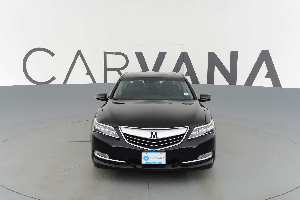

In [34]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [35]:
list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('data/carvana/train_masks/9274d0b3caa8_08_mask.gif'),
 PosixPath('data/carvana/train_masks/e114fcbb9723_08_mask.gif'),
 PosixPath('data/carvana/train_masks/5bcde75955bb_08_mask.gif'),
 PosixPath('data/carvana/train_masks/3cb21125f126_08_mask.gif'),
 PosixPath('data/carvana/train_masks/08a646be6b30_07_mask.gif')]

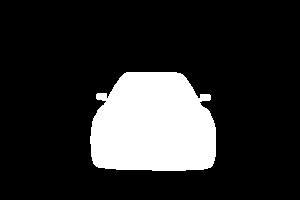

In [36]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [37]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

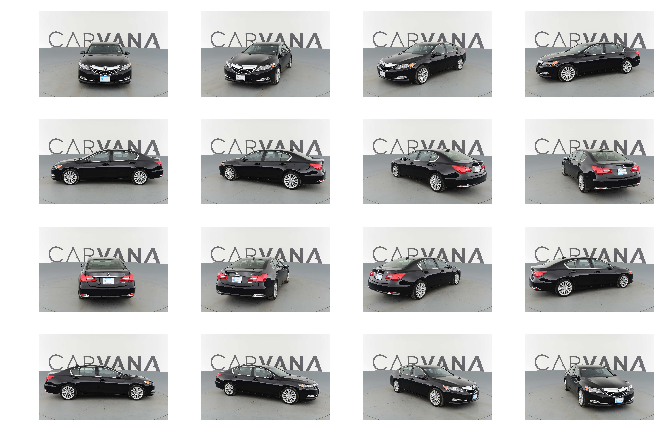

In [38]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

In [39]:
convert = False

In [40]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [41]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [42]:
if convert:
    files = list((PATH/'train_masks').iterdir())
    with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [43]:
def resize_mask(m):
    fn, sz = m
    Image.open(fn).resize((sz,sz)).save((fn.parent.parent)/f'train_masks-{sz}'/fn.name)

def get_masks(sz):
    return list((m, sz) for m in (PATH/'train_masks_png').iterdir())

def resize_img(i):
    fn, sz = i
    Image.open(fn).resize((sz,sz)).save((fn.parent.parent)/f'train-{sz}'/fn.name)

def get_images(sz):
    return list((i, sz) for i in (PATH/'train').iterdir())
    
if convert:
    for s in [128, 512, 1024]:
        masks = get_masks(s)
        (PATH/f'train_masks-{s}').mkdir(exist_ok=True)
        with ThreadPoolExecutor(8) as e: e.map(resize_mask, masks)

        images = get_images(s)
        (PATH/f'train-{s}').mkdir(exist_ok=True)
        with ThreadPoolExecutor(8) as e: e.map(resize_img, images)

## Show Cars with Masks

In [44]:
def show_cars_masks(sz, rows, cols, figsize):
    ims = [open_image(PATH/f'train-{sz}/{CAR_ID}_{i+1:02d}.jpg') for i in range(rows*cols)]
    im_masks = [open_image(PATH/f'train_masks-{sz}/{CAR_ID}_{i+1:02d}_mask.png') for i in range(rows*cols)]
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i,ax in enumerate(axes.flat):
        ax = show_img(ims[i], ax=ax)
        show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
    plt.tight_layout(pad=0.1)

In [45]:
def show_cars_mask_dl(md, rows, cols):
    denorm = md.trn_ds.denorm
    x,y = map(denorm, next(iter(md.aug_dl)))
    fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
    for i,ax in enumerate(axes.flat):
        ax=show_img(x[i], ax=ax)
        show_img(y[i][...,0], ax=ax, alpha=0.5)
    plt.tight_layout(pad=0.1)

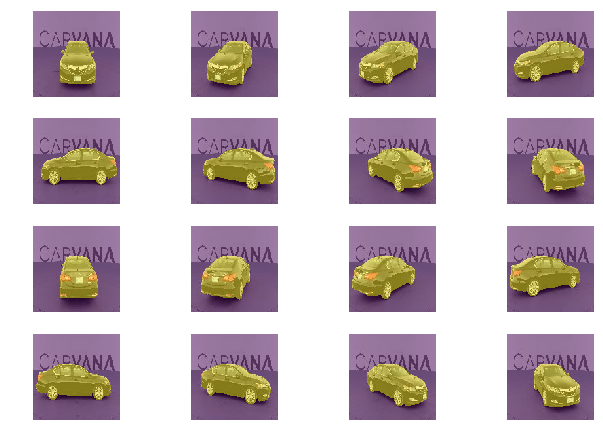

In [46]:
show_cars_masks(128, 4, 4, (9,6))

## Model

In [47]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [48]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [49]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[:,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[:,0], 0.5)

def dice(pred, targ):
    m1 = (pred[:,0]>0).float()
    m2 = targ[:,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

In [50]:
def get_model(sz, bs, num_workers, transf):
    x_names = np.array([Path(f'train-{sz}')/o for o in masks_csv['img']])
    y_names = np.array([Path(f'train_masks-{sz}')/f'{o[:-4]}_mask.png' for o in masks_csv['img']])
    val_idxs = list(range(len(x_names)//16//5*16))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    
    aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
                RandomFlip(tfm_y=TfmType.PIXEL),
                RandomLighting(0.05, 0.05)]
    
    tfms = tfms_from_model(transf, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=num_workers, classes=None)
    
    simple_up = nn.Sequential(
        nn.ReLU(),
        StdUpsample(512,256),
        StdUpsample(256,256),
        StdUpsample(256,256),
        StdUpsample(256,256),
        nn.ConvTranspose2d(256, 1, 2, stride=2),)
    
    models = ConvnetBuilder(vgg16, 0, 0, 0, custom_head=simple_up)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=mask_loss
    learn.metrics=[mask_acc, dice]
    
    return learn, md

## 128x128

In [57]:
learn, md = get_model(128, 64, 8, resnet34)

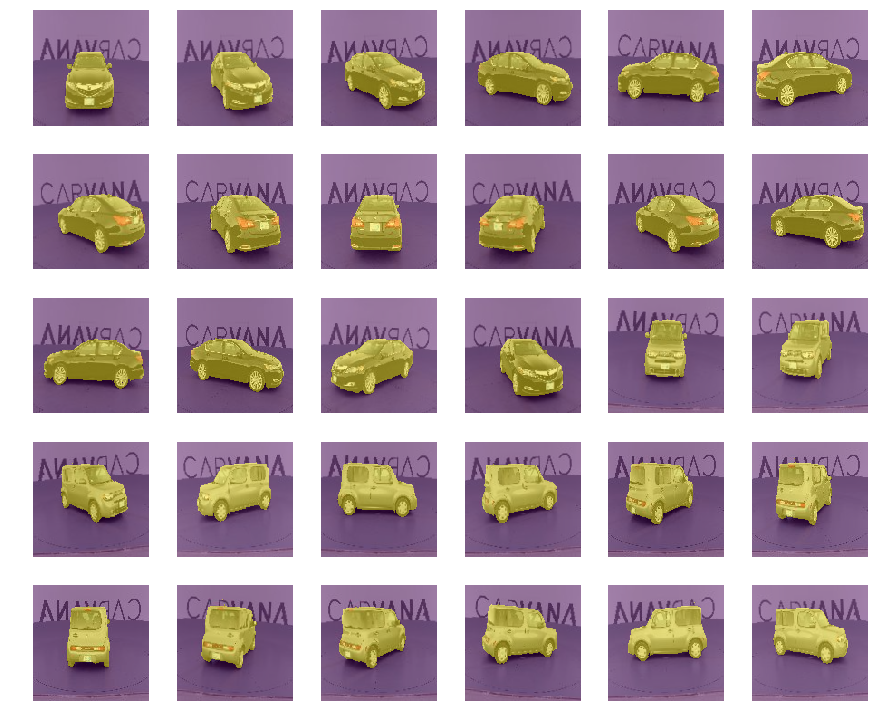

In [52]:
show_cars_mask_dl(md, 5, 6)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▉ | 57/64 [00:09<00:01,  5.90it/s, loss=6.39] 


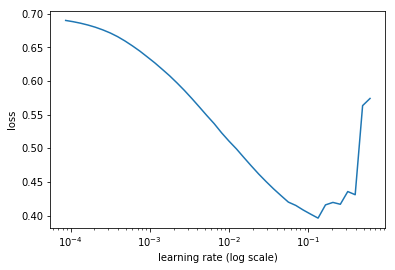

In [53]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(10,5))

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
py,ay = learn.predict_with_targs()

In [ ]:
show_img(np.rollaxis(ay[0], 0, 3))

In [ ]:
show_img(py[0][0]>0);

In [ ]:
learn.unfreeze()

In [ ]:
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('128')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(denorm(y)[0,...,-1], ax=ax, alpha=0.5);

## 512x512

In [54]:
learn, md = get_model(512, 16, 4, resnet34)

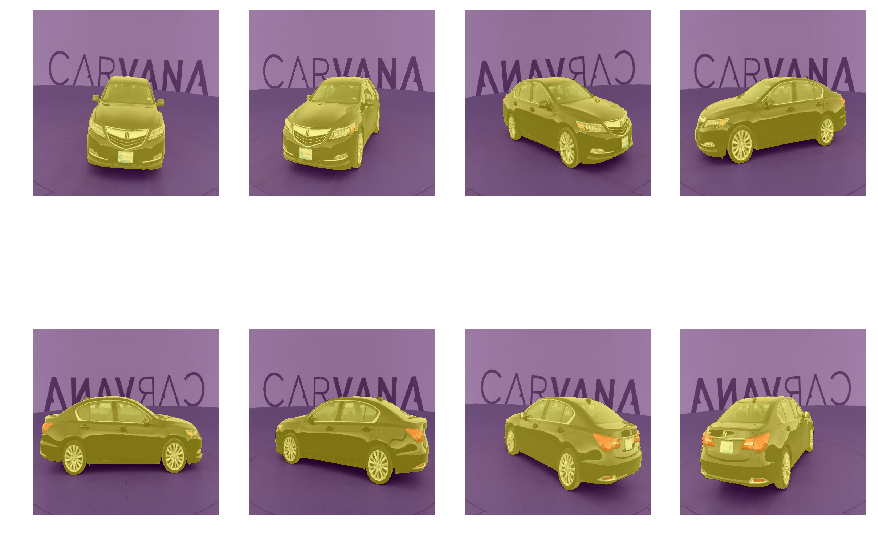

In [55]:
show_cars_mask_dl(md, 2, 4)

In [ ]:
learn.load('128')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 86%|████████▋ | 220/255 [02:31<00:24,  1.45it/s, loss=0.859] 

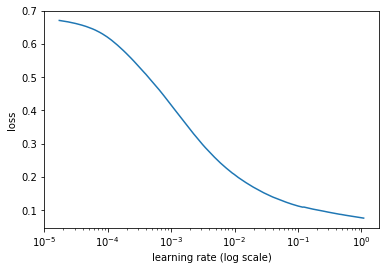

In [56]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save('512')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(denorm(y)[0,...,-1], ax=ax, alpha=0.5);

## 1024x1024

In [ ]:
learn, md = get_model(1024, 8, 4, resnet34)

In [ ]:
learn.load('512')

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2

In [ ]:
%memit learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/8

In [ ]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

In [ ]:
learn.save('1024')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);

## Fin

In [ ]:
x,y = next(iter(md.val_dl))

In [ ]:
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
